### (3) Forecast Regressions

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os

df = pd.read_excel('/home/lwright02/Quant-Summer-2025/data/gmo_analysis_data.xlsx', sheet_name='signals', index_col=0, parse_dates=True)

#Shift Data One Period and Drop Rows with NaNs
df[['dp_lag', 'ep_lag', 'y10_lag']] = df[['SPX D/P', 'SPX E/P', 'T-Note 10YR']].shift(1)

df = df.dropna(subset=['dp_lag', 'ep_lag', 'y10_lag'])

returns = pd.read_excel('/home/lwright02/Quant-Summer-2025/data/gmo_analysis_data.xlsx', sheet_name='total returns', index_col=0, parse_dates=True)
y = returns['SPY']
y = y.loc[df.index]

X1 = sm.add_constant(df[['dp_lag']])
X2 = sm.add_constant(df[['ep_lag']])
X3 = sm.add_constant(df[['dp_lag', 'ep_lag', 'y10_lag']])

model1 = sm.OLS(y, X1).fit()
model2 = sm.OLS(y, X2).fit()
model3 = sm.OLS(y, X3).fit()

print("\n--- Dividend-Price Regression ---")
print(model1.summary())

print("\n--- Earnings-Price Regression ---")
print(model2.summary())

print("\n--- Combined Predictors Regression ---")
print(model3.summary())



--- Dividend-Price Regression ---
                            OLS Regression Results                            
Dep. Variable:                    SPY   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     2.962
Date:                Sat, 12 Jul 2025   Prob (F-statistic):             0.0862
Time:                        13:16:48   Log-Likelihood:                 580.92
No. Observations:                 342   AIC:                            -1158.
Df Residuals:                     340   BIC:                            -1150.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.

### DP Regression: 
- Alpha: -0.0098, Beta: 1.0243, R^2: 0.009
### EP Regression: 
- Alpha: -0.0029, Beta: 0.2220, R^2: 0.003
### Combined Regression: 
- const: -0.0036
- DP: 1.4845
- EP: -0.2392
- 10Y:-0.0572
- r^2 = 0.010

In [10]:
def simulate_strategy(preds, actual_returns):
    wt = 100 * preds
    strategy_returns = wt * actual_returns
    return strategy_returns

# Forecasts
forecast1 = model1.predict(X1)
forecast2 = model2.predict(X2)
forecast3 = model3.predict(X3)

# Strategy returns
rx1 = simulate_strategy(forecast1, y)
rx2 = simulate_strategy(forecast2, y)
rx3 = simulate_strategy(forecast3, y)

# Function to evaluate strategy
def strategy_stats(rx, market=None):
    if market is None:
        market = y
    
    market = market.loc[rx.index]
    mean = rx.mean()
    vol = rx.std()
    sharpe = mean / vol if vol != 0 else np.nan
    max_dd = (rx.cumsum().cummax() - rx.cumsum()).max()
    var5 = rx.quantile(0.05)

    # Regression on market
    X = sm.add_constant(pd.DataFrame({'market': market}))
    reg = sm.OLS(rx, X).fit()
    if 'const' in reg.params:
        alpha = reg.params['const']
    else:
        alpha = 0.0
    if 'market' in reg.params:
        beta = reg.params['market']
    else:
        beta = reg.params.drop('const', errors='ignore').iloc[0]
    residual = reg.resid
    ir = alpha / residual.std() if residual.std() != 0 else np.nan

    return {
        'Mean': mean,
        'Volatility': vol,
        'Sharpe': sharpe,
        'Max Drawdown': max_dd,
        'VaR 5%': var5,
        'Alpha': alpha,
        'Beta': beta,
        'Information Ratio': ir
    }

print("Stats for DP model:\n", strategy_stats(rx1))
print("Stats for EP model:\n", strategy_stats(rx2))
print("Stats for All 3 predictors:\n", strategy_stats(rx3))

Stats for DP model:
 {'Mean': np.float64(0.009259095632300669), 'Volatility': np.float64(0.049281550154999104), 'Sharpe': np.float64(0.18788158252285472), 'Max Drawdown': np.float64(1.1076798573964686), 'VaR 5%': np.float64(-0.060588723980632815), 'Alpha': np.float64(0.0009840304580290855), 'Beta': np.float64(0.9522170776797179), 'Information Ratio': np.float64(0.039166624949123756)}
Stats for EP model:
 {'Mean': np.float64(0.008181539035536376), 'Volatility': np.float64(0.04274873781783102), 'Sharpe': np.float64(0.19138668071092746), 'Max Drawdown': np.float64(0.8731569735505356), 'VaR 5%': np.float64(-0.06285319142478252), 'Alpha': np.float64(0.0002776472616945689), 'Beta': np.float64(0.9095059155043955), 'Information Ratio': np.float64(0.02026893727274129)}
Stats for All 3 predictors:
 {'Mean': np.float64(0.009576655100672888), 'Volatility': np.float64(0.04941785706327978), 'Sharpe': np.float64(0.19378936420512813), 'Max Drawdown': np.float64(1.0271082071218132), 'VaR 5%': np.float6

,Mean,Volatility,Sharpe,Max Drawdown,VaR 5%,Alpha,Beta,Information Ratio
DP Strategy,0.004480,6.247038e-02,7.171211e-02,1.107680,-0.076893,0.0,2.986588,0.0
EP Strategy,0.003082,5.132155e-02,6.005349e-02,0.873157,-0.080088,0.0,2.054692,0.0
Combined Strategy,0.004313,5.969742e-02,7.224039e-02,1.027108,-0.064087,0.0,2.875043,0.0
Risk-Free,0.001500,2.175973e-19,6.893468e+15,NaN,NaN,0.0,0.000000,0.0


<Figure size 1000x600 with 0 Axes>

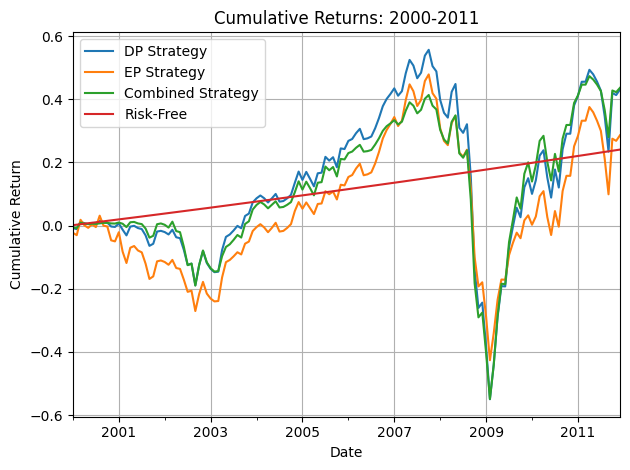

In [12]:
try:
    rf
except NameError:
    rf = pd.Series(0.0015, index=rx1.index, name='Risk-Free')

# Build DataFrame with all strategy returns + risk-free
forecast_model = pd.DataFrame({
    'DP Strategy': rx1,
    'EP Strategy': rx2,
    'Combined Strategy': rx3,
    'Risk-Free': rf
})

# Subset to 2000-2011
forecast_subsample = forecast_model.loc['2000':'2011']

def calc_performance_metrics(df):
    # Compute performance for each column strategy_stats function in 3.2
    results = {}
    for col in df.columns:
        if col == 'Risk-Free':
            mean = df[col].mean()
            vol = df[col].std()
            sharpe = mean / vol if vol != 0 else float('nan')
            results[col] = {
                'Mean': mean,
                'Volatility': vol,
                'Sharpe': sharpe,
                'Max Drawdown': float('nan'),
                'VaR 5%': float('nan'),
                'Alpha': 0.0,
                'Beta': 0.0,
                'Information Ratio': 0.0
            }
        else:
            results[col] = strategy_stats(df[col], market=df['Risk-Free'])
    return pd.DataFrame(results)

# Performance metrics for 2000-2011 period
perf_metrics = calc_performance_metrics(forecast_subsample).T
display(perf_metrics)

# Plot cumulative returns over 2000-2011
plt.figure(figsize=(10,6))
(cumulative := (forecast_subsample + 1).cumprod() - 1).plot()
plt.title('Cumulative Returns: 2000-2011')
plt.ylabel('Cumulative Return')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.show()

The DP Strategy consistently outperforms the other strategies and the risk-free asset for most of the period. Particularly after 2003, DP returns accelerate and maintain a lead, contradicting the underperformance seen in traditional stock portfolios during this era. All strategies suffer a significant drop during the 2008 financial crisis, with cumulative returns dropping below -0.4.

There are two periods where we estimate negative risk premium. 2001-2005, and 2008-2011.

It is likely that increased risk has something to do with the out-performance of rx and rgmo. The DP and Combined Strategies exhibit higher volatility than the Risk-Free benchmark—signaling, however the association could also lie in market timing.